# L&S 88 - Lab 5 - Data Visualization with `matplotlib.pyplot`

_Data and original analysis from [Stuart Geiger](https://github.com/staeiou/wiki-pageview-notebook), adapted with added analysis by Chris Pyles_

In this lab, we'll cover the basics of one of the most important aspects of data science: data visualization. By this point, you should have some familarity with data visualization from the builtin `Table` methods that allow you to create plots, histograms, and the like, but today we'll cover the tool that underlies all of those: `pyplot`. The `pyplot` library, a subset of a larger plotting library called `matplotlib`, is a very powerful (if unintiuitive) tool that allows you to create robust data visualizations in Python. While there are some other tools that can be used in conjunction with `pyplot` and which make the code easier to write and understand (e.g. `seaborn`, `altair`), we won't be covering those in this lesson.

**Before you continue in this lab, please take time to complete the [`pyplot` tutorial](pyplot.ipynb).** This will give you the basic building blocks to understand how to answer the questions in this lab. If you find yourself struggling with a plot, post on Piazza or _Google the function_. We cannot stress enough how helpful this is. For example, if you didn't know how to choose where the $x$ ticks fall on a scatter plot, you should start by googling "pyplot xticks" and go from there.

In [145]:
from datascience import *
import datetime as dt
import numpy as np
import pandas as pd

# the standard pyplot abbreviation is plt
import matplotlib.pyplot as plt

# this sets the colorscheme and style of the plots create in this notebook
plt.style.use('fivethirtyeight')

# this Jupyter magic command tells IPython to display the plots right after they're generated
%matplotlib inline

In this lab, we'll be working with a data set generated by Stuart Geiger on the number of pageviews for the Wikipedia pages of members of the U.S. Congress. If you're interested, the code that was used to generate the data sets loaded below and the original analysis are hosted [on Github](https://github.com/staeiou/wiki-pageview-notebook). The `house` and `senate` tables below contain one column for each member of the House and Senate, respectively, and one row for each month from January 2016 to December 2018. Each cell contains the number of pageviews for that member of Congress in the given month. We'll be looking at trends in these pageviews across and within houses of Congress, and for individual legislators. The goal of this lab is to familiarize you with the `matplotlib.pyplot` library for creating data visualizations.

In [146]:
house = Table.read_table('house_views.csv')
# print('columns =', house.num_columns )
house.show(5)
senate = Table.read_table('senate_views.csv')
# print('columns =', senate.num_columns )
senate.show(5)

Month,Adam_Kinzinger,Adam_Schiff,Adam_Smith_(politician),Adrian_Smith_(politician),Adriano_Espaillat,Al_Green_(politician),Al_Lawson,Alan_Lowenthal,Albio_Sires,Alcee_Hastings,Alex_Mooney,Alma_Adams,Ami_Bera,André_Carson,Andy_Barr_(U.S._politician),Andy_Biggs_(politician),Andy_Harris,Ann_McLane_Kuster,Ann_Wagner,Anna_Eshoo,Anthony_G._Brown,Austin_Scott_(politician),Barbara_Comstock,Barbara_Lee,Barry_Loudermilk,Ben_Luján,Bennie_Thompson,Beto_O'Rourke,Betty_McCollum,Bill_Flores,Bill_Foster_(politician),Bill_Huizenga,Bill_Johnson_(Ohio_politician),Bill_Keating_(politician),Bill_Pascrell,Bill_Posey,Bill_Shuster,Billy_Long,Blaine_Luetkemeyer,Blake_Farenthold,Bob_Brady,Bob_Gibbs,Bob_Goodlatte,Bob_Latta,Bobby_Rush,Bobby_Scott_(politician),Bonnie_Watson_Coleman,Brad_Schneider,Brad_Sherman,Brad_Wenstrup,Bradley_Byrne,Brenda_Lawrence,Brendan_F._Boyle,Brett_Guthrie,Brian_Babin,Brian_Fitzpatrick_(American_politician),Brian_Higgins,Brian_Mast,Bruce_Poliquin,Bruce_Westerman,Buddy_Carter,Carlos_Curbelo_(politician),Carol_Shea-Porter,Carolyn_Maloney,Cathy_McMorris_Rodgers,Cedric_Richmond,Charlie_Crist,Charlie_Dent,Chellie_Pingree,Cheri_Bustos,Chris_Collins_(U.S._politician),Chris_Smith_(New_Jersey_politician),Chris_Stewart_(politician),Chuck_Fleischmann,Claudia_Tenney,Clay_Higgins,Colleen_Hanabusa,Collin_Peterson,Dan_Donovan_(politician),Dan_Kildee,Dan_Lipinski,Dan_Newhouse,Dana_Rohrabacher,Daniel_Webster_(Florida_politician),Danny_K._Davis,Darin_LaHood,Darrell_Issa,Darren_Soto,Dave_Brat,Dave_Loebsack,Dave_Reichert,David_Cicilline,David_Joyce_(politician),David_Kustoff,David_McKinley,David_Price_(U.S._politician),David_Rouzer,David_Schweikert,David_Scott_(Georgia_politician),David_Trott,David_Valadao,David_Young_(Iowa_politician),Debbie_Dingell,Debbie_Wasserman_Schultz,Dennis_Heck,Dennis_Ross,Derek_Kilmer,Devin_Nunes,Diana_DeGette,Diane_Black,Dina_Titus,Don_Bacon_(politician),Don_Beyer,Don_Young,Donald_McEachin,Donald_Norcross,"Donald_Payne,_Jr.",Doris_Matsui,Doug_Collins_(politician),Doug_LaMalfa,Doug_Lamborn,Drew_Ferguson_(politician),Duncan_D._Hunter,Dutch_Ruppersberger,Dwight_Evans_(politician),Earl_Blumenauer,Ed_Perlmutter,Ed_Royce,Eddie_Johnson,Elijah_Cummings,Eliot_Engel,Elise_Stefanik,Elizabeth_Esty,Emanuel_Cleaver,Eric_Swalwell,Erik_Paulsen,Evan_Jenkins_(politician),"Filemon_Vela,_Jr.",Francis_Rooney,Frank_LoBiondo,Frank_Lucas_(Oklahoma_politician),Frank_Pallone,Fred_Upton,Frederica_Wilson,French_Hill_(politician),G._K._Butterfield,Garret_Graves,Gary_Palmer_(politician),Gene_Green,George_Holding,Gerry_Connolly,Glenn_Grothman,Glenn_Thompson_(politician),Grace_Meng,Grace_Napolitano,Greg_Walden,Gregg_Harper,Gregory_Meeks,Gus_Bilirakis,Gwen_Moore,Hakeem_Jeffries,Hal_Rogers,Hank_Johnson,Henry_Cuellar,Ileana_Ros-Lehtinen,Jack_Bergman,Jackie_Speier,Jackie_Walorski,Jacky_Rosen,Jaime_Herrera_Beutler,James_Comer_(politician),Jamie_Raskin,Jan_Schakowsky,Jared_Huffman,Jared_Polis,Jason_Chaffetz,Jason_Lewis_(congressman),Jason_T._Smith,Jeb_Hensarling,Jeff_Denham,Jeff_Duncan_(politician),Jeff_Fortenberry,Jerrold_Nadler,Jerry_McNerney,Jim_Banks,Jim_Bridenstine,Jim_Clyburn,Jim_Cooper,Jim_Costa,Jim_Himes,Jim_Jordan_(U.S._politician),Jim_Langevin,Jim_McGovern_(U.S._politician),Jim_Renacci,Jim_Sensenbrenner,Jimmy_Duncan_(U.S._politician),Jimmy_Panetta,Joaquín_Castro,Jodey_Arrington,Jody_Hice,Joe_Barton,Joe_Courtney_(politician),Joe_Kennedy,Joe_Wilson_(U.S._politician),John_B._Larson,John_Carter_(Texas_politician),John_Conyers,John_Culberson,John_Delaney,John_Faso,John_Garamendi,John_Katko,John_Lewis_(civil_rights_leader),John_Moolenaar,John_Ratcliffe_(American_politician),John_Rutherford_(Florida_politician),John_Sarbanes,John_Shimkus,John_Yarmuth,Joseph_Crowley,Josh_Gottheimer,José_Serrano,Joyce_Beatty,Juan_Vargas,Judy_Chu,Julia_Brownley,Justin_Amash,Karen_Bass,Katherine_Clark,Kathleen_Rice,Kathy_Castor,Kay_Granger,Keith_Ellison,Keith_Rothfus,Ken_Buck,Ken_Calvert,Kenny_Marchant,Kevin_Brady,Kevin_Cramer,Kevin_McCarthy_(California_politician),Kevin_Yoder

Month,Al_Franken,Amy_Klobuchar,Angus_King,Ben_Cardin,Ben_Sasse,Bernie_Sanders,Bill_Cassidy,Bill_Nelson,Bob_Casey_Jr.,Bob_Corker,Bob_Menendez,Brian_Schatz,Catherine_Cortez_Masto,Chris_Coons,Chris_Murphy_(Connecticut_politician),Chris_Van_Hollen,Chuck_Grassley,Chuck_Schumer,Claire_McCaskill,Cory_Booker,Cory_Gardner,Dan_Sullivan_(U.S._Senator),David_Perdue,Dean_Heller,Deb_Fischer,Debbie_Stabenow,Dianne_Feinstein,Dick_Durbin,Ed_Markey,Elizabeth_Warren,Gary_Peters_(politician),Heidi_Heitkamp,Jack_Reed_(politician),James_Lankford,Jeanne_Shaheen,Jeff_Flake,Jeff_Merkley,Jerry_Moran,Jim_Inhofe,Jim_Risch,Joe_Donnelly,Joe_Manchin,John_Barrasso,John_Boozman,John_Cornyn,John_Hoeven,John_McCain,John_N._Kennedy,John_Thune,Johnny_Isakson,Jon_Tester,Joni_Ernst,Kamala_Harris,Kirsten_Gillibrand,Lamar_Alexander,Lindsey_Graham,Lisa_Murkowski,Luther_Strange,Maggie_Hassan,Marco_Rubio,Maria_Cantwell,Mark_Warner,Martin_Heinrich,Mazie_Hirono,Michael_Bennet,Mike_Crapo,Mike_Enzi,Mike_Lee_(U.S._politician),Mike_Rounds,Mitch_McConnell,Orrin_Hatch,Pat_Roberts,Pat_Toomey,Patrick_Leahy,Patty_Murray,Rand_Paul,Richard_Blumenthal,Richard_Burr,Richard_Shelby,Rob_Portman,Roger_Wicker,Ron_Johnson_(U.S._politician),Ron_Wyden,Roy_Blunt,Sheldon_Whitehouse,Shelley_Moore_Capito,Sherrod_Brown,Steve_Daines,Susan_Collins,Tammy_Baldwin,Tammy_Duckworth,Ted_Cruz,Thad_Cochran,Thom_Tillis,Tim_Kaine,Tim_Scott,Todd_Young,Tom_Carper,Tom_Cotton,Tom_Udall
2016-01,40768,10282,13743,5774,19451,1.72746e+06,4499,13754,88,7418,9294,6740,3085,4903,9094,6679,16709,55327,13960,44700,7375,775,4437,3915,4628,9669,36146,15779,9279,136363,5848,4960,6339,6162,9314,6737,4398,4184,10411,3689,5375,7413,3822,4457,16096,3334,252746,65,9404,6432,4918,16801,20167,26493,9763,46042,12308,818,13041,514100,6987,11080,5385,8501,9422,3606,3856,0,3095,33299,36571,4354,10297,38866,8895,223155,12316,9792,18582,11332,4120,7190,8857,7675,5636,5380,10126,4671,12363,11753,15202,1.35248e+06,6480,6148,16630,13176,2525,3835,24117,6253
2016-02,42661,40245,19517,7716,28501,3.58826e+06,5482,20045,101,10224,14837,9112,6246,6962,9352,9569,25669,55546,19363,120228,10171,5288,7789,9943,6748,9176,39386,21995,13316,251797,6324,7178,6310,5666,20238,11815,4471,4741,11239,4391,7167,9303,4568,5861,26413,4309,287721,73,8067,9886,6076,15662,87830,31028,14223,80023,12601,885,25892,1.86314e+06,8574,16435,6427,12117,12573,4249,4335,0,3830,94428,59270,6785,20203,57757,11509,171396,16201,12036,21191,15656,5037,9221,9988,9923,9116,7370,15929,4648,17014,15242,29774,2.27243e+06,8357,9979,21087,48370,4778,4505,19042,6822
2016-03,69646,22588,18929,7535,46198,2.02613e+06,5963,20002,110,10139,15879,11376,6426,6676,10502,15807,27369,43496,12915,148369,10075,5720,9501,5059,6914,10689,39737,24089,14721,263435,7853,6355,6286,6339,11949,15783,5493,6512,17171,5008,8019,10329,5706,5437,28753,4599,239321,63,8916,10100,7416,11903,33522,31428,12546,95282,11930,1166,14844,1.06037e+06,10629,17592,6604,13466,14214,5037,4531,0,4416,107192,60510,7594,18431,74701,13627,96366,14623,16464,16288,22641,5745,11941,9512,10904,7977,7592,38094,4953,19880,16726,73608,1.69609e+06,9415,9583,24815,14893,5325,4740,25662,7833
2016-04,43087,19740,13951,7733,9943,1.33799e+06,5047,12413,95,8403,12450,7667,4653,5790,10072,33189,16840,50333,13323,67708,8527,4499,4877,4185,4760,9515,46832,17401,12180,160696,6128,5860,6106,4928,10742,7907,24060,4945,10259,4933,7427,8778,5029,4419,18072,4365,161044,55,8556,7048,7912,13594,36393,32458,10374,36592,10964,1244,11950,106018,8377,19597,5495,9120,11374,4005,4605,0,3677,38192,36014,5788,22137,41565,10823,54324,11446,11853,9713,12295,4681,10852,12469,8763,6987,6404,26198,4474,19470,16352,19009,846753,6925,6260,30793,10561,11301,5523,16602,8272
2016-05,66366,16663,13341,5532,78686,787078,4644,11750,2146,53781,9764,7618,5662,5366,8809,7070,12336,41958,12262,56338,8882,5184,6035,4923,8774,7787,49830,15788,12730,393792,5354,6001,5233,5738,9637,12124,9110,3832,8639,3206,7278,10741,5425,4828,15533,3943,201562,73,12707,9919,6695,51981,89298,23929,

## Part 1: Data Cleaning
Before we can do much with the data that we have collected, we need to do a bit of data cleaning. For this particular project, the only real cleaning we have to do is convert the dates in both tables to something that we can use to analyze time trends. Python has a builtin library called `datetime` (std. abbrev.: `dt`) which allows for robust comparison and manipulation of dates.

**Question 1.** The `month_to_dt` function (defined for you) converts a string to a `datetime` object. Apply this function to the `Month` column of both `house` and `senate`, storing the results as `house_months` and `senate_months`, respectively. The last two lines of code replace the strings in the tables with the `datetime` objects.

In [147]:
def month_to_dt(entry):
    return dt.datetime.strptime(entry, '%Y-%m')

house_months = house.apply(month_to_dt, 'Month')
senate_months = senate.apply(month_to_dt, 'Month')

house['Month'] = house_months
senate['Month'] = senate_months

## Part 2: Aggregate Pageviews
Let's say that we wanted to look at how the number of pageviews for congresspersons is changing over time. The first thing we would need to do is aggregate the data that we have collected across columns into a total pageview number for each month (row) in the table.

**Question 2a.** Iterate over the rows in the `house` table and store the sum of each row in `row_sums`. Then add a column to `house` with the values in `row_sums`.

In [151]:
def sum_rows(table):
    hits = []
#     print('Number of columns =', table.num_columns)
    for row in range(table.num_rows):
        hits_per_month = house.row(row)
        running_sum = 0

        for column in range(1, table.num_columns):
            running_sum += hits_per_month.item(column)

        hits.append(running_sum)

    return hits

h_row_sums = sum_rows(house)
house_totals = house.with_column('view sums', h_row_sums)

# house_totals

**Question 2b.** The code below creates a barplot of the number of pageviews over each month in the `house` table. Add code to it to include the following elements:
* Title: `Monthly Wikipedia pageviews for U.S. House of Representatives`
* $x$ label: `Month`
* $y$ label: `Number of pageviews`

Also, don't forget the semicolon `;` so that Jupyter doesn't output any text.

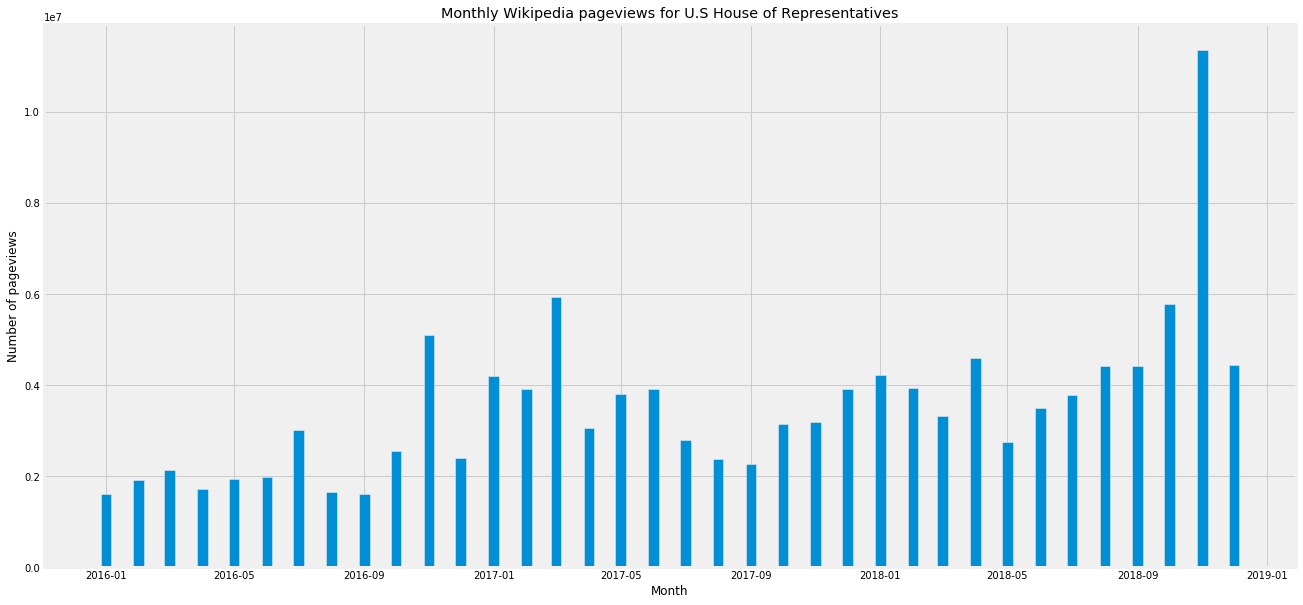

In [152]:
plt.figure(figsize=[20, 10])
plt.bar(house_totals.column('Month'), house_totals.column('view sums'), width=10)

plt.title('Monthly Wikipedia pageviews for U.S House of Representatives')
plt.xlabel('Month')
plt.ylabel('Number of pageviews');

Now we'll do a similar analysis for the `senate` table.

**Question 3a.** Iterate over the rows in the `senate` table and store the sum of each row in `row_sums`. Then add a column to `senate` with the values in `row_sums`.

In [153]:
s_row_sums = sum_rows(senate)
senate_totals = senate.with_column('view sums', s_row_sums)

# senate_totals

**Question 3b.** Create another barplot, this time for the `senate` table, similar to the one above. Use the same axis labels, but change the title to read `Monthly Wikipedia pageviews for U.S. Senate`. Your plot should look like this:

<img src="q3b.png" width="1000px" />

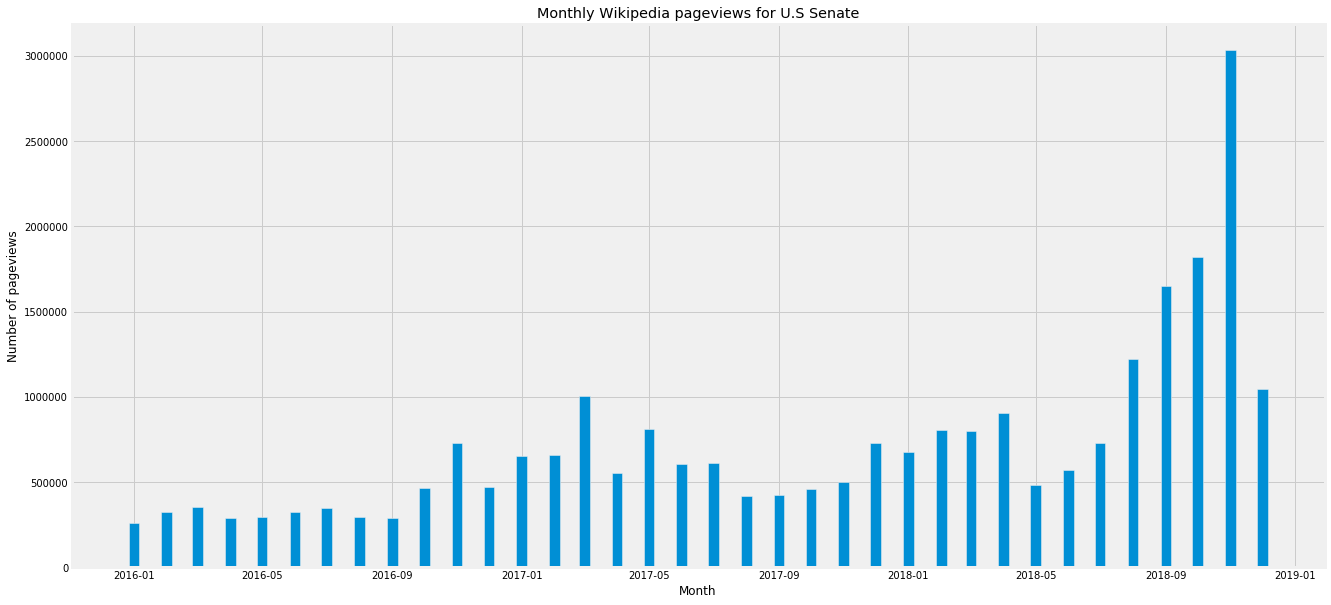

In [154]:
plt.figure(figsize=[20, 10])
plt.bar(senate_totals.column('Month'), senate_totals.column('view sums'), width=10)

plt.title('Monthly Wikipedia pageviews for U.S Senate')
plt.xlabel('Month')
plt.ylabel('Number of pageviews');

Now let's look at aggregates across both houses of Congress. In order to mainpulate the tables in the format that we have them, we need to do some work using `pandas`, a Python library that deals with tables and data manipulation. You should look over the code below and try to understand it, but you don't need to be able to do anything of the sort until you take Data 100.

In [155]:
house_df = house.to_df()     # convert house table to pandas dataframe
senate_df = senate.to_df()   # convert senate table to pandas dataframe

house_t = house_df.transpose()     # take transpose of house dataframe (rows become columns & columns becom rows)
senate_t = senate_df.transpose()   # take transpose of house dataframe (rows become columns & columns becom rows)

house_t.columns = house_t.loc['Month']     # set columns of house df to the row labeled 'Month'
house_t = house_t.iloc[1:]                 # remove the row labeled 'Month' from the df

senate_t.columns = senate_t.loc['Month']   # set columns of senate df to the row labeled 'Month'
senate_t = senate_t.iloc[1:]               # remove the row labeled 'Month' from the df

congress_df = house_t.append(senate_t).reset_index()    # append senate df to end of house df
congress_df = congress_df.transpose()                   # take the transpose of the congress df
congress_df.columns = congress_df.loc['index']          # set columns to the row labeled 'index'
congress_df = congress_df.iloc[1:].reset_index()        # remove the row labeled 'index' and reset the df index
congress_df.to_csv('congress_views.csv', index=False)   # export to csv file without the df index

congress = Table.read_table('congress_views.csv')                                          # read in congress.csv as Table
congress_months = congress.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'), 'Month')   # convert 'Month' column to dt objects
congress['Month'] = congress_months                                                        # replace string months with dt months
congress.show(5)

Month,Adam_Kinzinger,Adam_Schiff,Adam_Smith_(politician),Adrian_Smith_(politician),Adriano_Espaillat,Al_Green_(politician),Al_Lawson,Alan_Lowenthal,Albio_Sires,Alcee_Hastings,Alex_Mooney,Alma_Adams,Ami_Bera,André_Carson,Andy_Barr_(U.S._politician),Andy_Biggs_(politician),Andy_Harris,Ann_McLane_Kuster,Ann_Wagner,Anna_Eshoo,Anthony_G._Brown,Austin_Scott_(politician),Barbara_Comstock,Barbara_Lee,Barry_Loudermilk,Ben_Luján,Bennie_Thompson,Beto_O'Rourke,Betty_McCollum,Bill_Flores,Bill_Foster_(politician),Bill_Huizenga,Bill_Johnson_(Ohio_politician),Bill_Keating_(politician),Bill_Pascrell,Bill_Posey,Bill_Shuster,Billy_Long,Blaine_Luetkemeyer,Blake_Farenthold,Bob_Brady,Bob_Gibbs,Bob_Goodlatte,Bob_Latta,Bobby_Rush,Bobby_Scott_(politician),Bonnie_Watson_Coleman,Brad_Schneider,Brad_Sherman,Brad_Wenstrup,Bradley_Byrne,Brenda_Lawrence,Brendan_F._Boyle,Brett_Guthrie,Brian_Babin,Brian_Fitzpatrick_(American_politician),Brian_Higgins,Brian_Mast,Bruce_Poliquin,Bruce_Westerman,Buddy_Carter,Carlos_Curbelo_(politician),Carol_Shea-Porter,Carolyn_Maloney,Cathy_McMorris_Rodgers,Cedric_Richmond,Charlie_Crist,Charlie_Dent,Chellie_Pingree,Cheri_Bustos,Chris_Collins_(U.S._politician),Chris_Smith_(New_Jersey_politician),Chris_Stewart_(politician),Chuck_Fleischmann,Claudia_Tenney,Clay_Higgins,Colleen_Hanabusa,Collin_Peterson,Dan_Donovan_(politician),Dan_Kildee,Dan_Lipinski,Dan_Newhouse,Dana_Rohrabacher,Daniel_Webster_(Florida_politician),Danny_K._Davis,Darin_LaHood,Darrell_Issa,Darren_Soto,Dave_Brat,Dave_Loebsack,Dave_Reichert,David_Cicilline,David_Joyce_(politician),David_Kustoff,David_McKinley,David_Price_(U.S._politician),David_Rouzer,David_Schweikert,David_Scott_(Georgia_politician),David_Trott,David_Valadao,David_Young_(Iowa_politician),Debbie_Dingell,Debbie_Wasserman_Schultz,Dennis_Heck,Dennis_Ross,Derek_Kilmer,Devin_Nunes,Diana_DeGette,Diane_Black,Dina_Titus,Don_Bacon_(politician),Don_Beyer,Don_Young,Donald_McEachin,Donald_Norcross,"Donald_Payne,_Jr.",Doris_Matsui,Doug_Collins_(politician),Doug_LaMalfa,Doug_Lamborn,Drew_Ferguson_(politician),Duncan_D._Hunter,Dutch_Ruppersberger,Dwight_Evans_(politician),Earl_Blumenauer,Ed_Perlmutter,Ed_Royce,Eddie_Johnson,Elijah_Cummings,Eliot_Engel,Elise_Stefanik,Elizabeth_Esty,Emanuel_Cleaver,Eric_Swalwell,Erik_Paulsen,Evan_Jenkins_(politician),"Filemon_Vela,_Jr.",Francis_Rooney,Frank_LoBiondo,Frank_Lucas_(Oklahoma_politician),Frank_Pallone,Fred_Upton,Frederica_Wilson,French_Hill_(politician),G._K._Butterfield,Garret_Graves,Gary_Palmer_(politician),Gene_Green,George_Holding,Gerry_Connolly,Glenn_Grothman,Glenn_Thompson_(politician),Grace_Meng,Grace_Napolitano,Greg_Walden,Gregg_Harper,Gregory_Meeks,Gus_Bilirakis,Gwen_Moore,Hakeem_Jeffries,Hal_Rogers,Hank_Johnson,Henry_Cuellar,Ileana_Ros-Lehtinen,Jack_Bergman,Jackie_Speier,Jackie_Walorski,Jacky_Rosen,Jaime_Herrera_Beutler,James_Comer_(politician),Jamie_Raskin,Jan_Schakowsky,Jared_Huffman,Jared_Polis,Jason_Chaffetz,Jason_Lewis_(congressman),Jason_T._Smith,Jeb_Hensarling,Jeff_Denham,Jeff_Duncan_(politician),Jeff_Fortenberry,Jerrold_Nadler,Jerry_McNerney,Jim_Banks,Jim_Bridenstine,Jim_Clyburn,Jim_Cooper,Jim_Costa,Jim_Himes,Jim_Jordan_(U.S._politician),Jim_Langevin,Jim_McGovern_(U.S._politician),Jim_Renacci,Jim_Sensenbrenner,Jimmy_Duncan_(U.S._politician),Jimmy_Panetta,Joaquín_Castro,Jodey_Arrington,Jody_Hice,Joe_Barton,Joe_Courtney_(politician),Joe_Kennedy,Joe_Wilson_(U.S._politician),John_B._Larson,John_Carter_(Texas_politician),John_Conyers,John_Culberson,John_Delaney,John_Faso,John_Garamendi,John_Katko,John_Lewis_(civil_rights_leader),John_Moolenaar,John_Ratcliffe_(American_politician),John_Rutherford_(Florida_politician),John_Sarbanes,John_Shimkus,John_Yarmuth,Joseph_Crowley,Josh_Gottheimer,José_Serrano,Joyce_Beatty,Juan_Vargas,Judy_Chu,Julia_Brownley,Justin_Amash,Karen_Bass,Katherine_Clark,Kathleen_Rice,Kathy_Castor,Kay_Granger,Keith_Ellison,Keith_Rothfus,Ken_Buck,Ken_Calvert,Kenny_Marchant,Kevin_Brady,Kevin_Cramer,Kevin_McCarthy_(California_politician),Kevin_Yoder

The `congress` table now contains similar data to the `house` and `senate` tables, but now with 1 column for each representative and senator. We can, therefore, use similar code to create a plot of aggregate views over time.

**Question 4a.** Iterate over the rows in the `congress` table and store the sum of each row in `row_sums`. Then add a column to `congress` with the values in `row_sums`.

In [156]:
row_sums = np.array(h_row_sums) + np.array(s_row_sums)
congress = congress.with_column('view sums', row_sums)

# congress

**Question 4b.** This time, create a line plot for the `congress`, `house`, and `senate` tables (all in the same plot). Use the same axis labels, but change the title to read `Monthly Wikipedia pageviews for U.S. Congress`. Use dashed lines for the `house` and `senate` tables and include a legend in your plot; it should look like this:

<img src="q4b.png" width="1000px" />

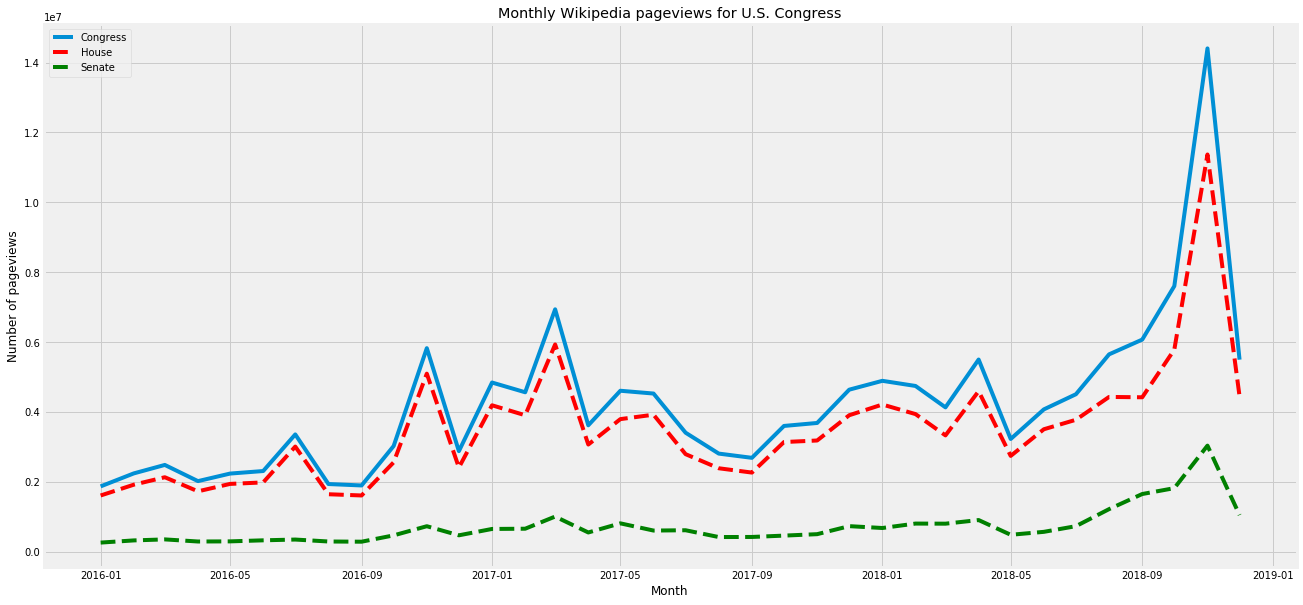

In [159]:
plt.figure(figsize=[20, 10])

plt.plot(congress.column('Month'), congress.column('view sums'), label='Congress')
plt.plot(house_totals.column('Month'), house_totals.column('view sums'), 'r--', label='House')
plt.plot(senate_totals.column('Month'), senate_totals.column('view sums'), 'g--', label='Senate')
plt.legend()
plt.xlabel('Month')
plt.ylabel('Number of pageviews')
plt.title('Monthly Wikipedia pageviews for U.S. Congress');

Finally, let's take a look at the distribution of pageviews for all of Congress. In order to get an idea of what the distribution of a variable looks like, we use a histogram. In the below cell, we plot the histogram for you with varying numbers of bins.

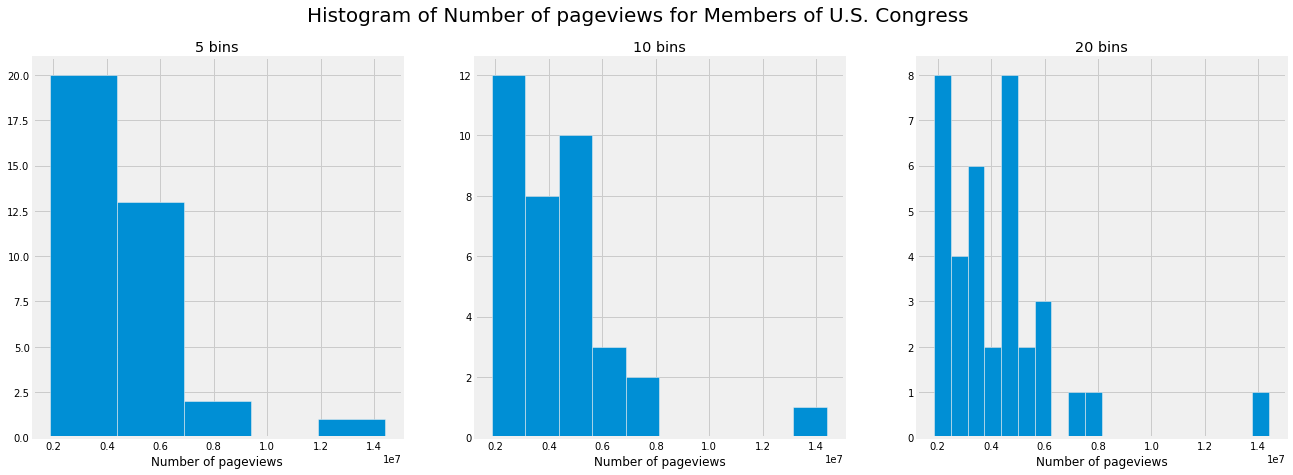

In [72]:
plt.figure(figsize=[20, 7])

plt.suptitle('Histogram of Number of pageviews for Members of U.S. Congress', size=20)

plt.subplot(131)
plt.hist(congress['view sums'], bins=5)
plt.title('5 bins')
plt.xlabel('Number of pageviews')

plt.subplot(132)
plt.hist(congress['view sums'], bins=10)
plt.title('10 bins')
plt.xlabel('Number of pageviews')

plt.subplot(133)
plt.hist(congress['view sums'], bins=20)
plt.title('20 bins')
plt.xlabel('Number of pageviews');

**Question 5.** What do you notice about how the distribution changes as we increase the number of bins? Why is this significant?

Increasing the number of bins makes the histogram more detailed.  You lose information by throwing more data into fewer bins.

## Part 3: Individual Trends
Now let's take a look at the trends for a few individual members of Congress. If we wanted to look at trends for one congressperson, say Nancy Pelosi, we could select the columns `Month` and `Nancy_Pelosi` from the `congress` table and make a plot of the pageviews for her Wikipedia page over time:

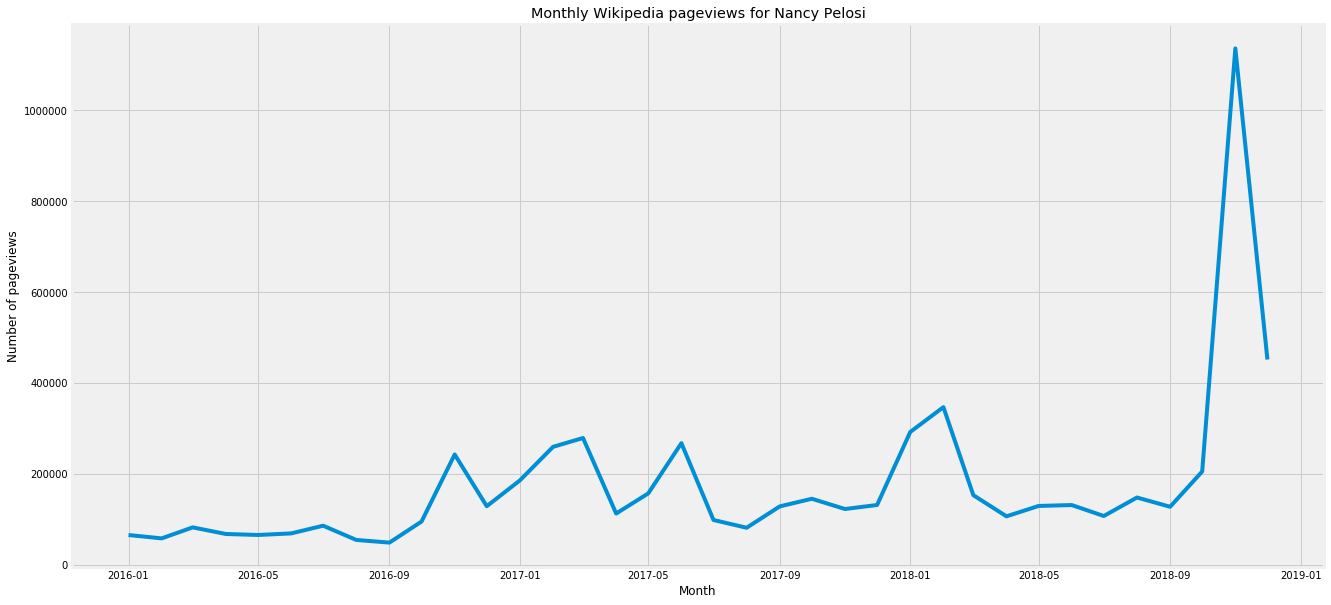

In [73]:
pelosi = congress.select('Month', 'Nancy_Pelosi')

plt.figure(figsize=[20, 10])
plt.plot(pelosi['Month'], pelosi['Nancy_Pelosi'])
plt.title('Monthly Wikipedia pageviews for Nancy Pelosi')
plt.xlabel('Month')
plt.ylabel('Number of pageviews');

You should see a spike in the plot right around November 2011; thinking about the context, this makes sense, because it was in this month that the Democrats took the House over and Nancy Pelosi was on track to become Speaker of the House.

**Question 6.** Choose two legislators in the `congress` table. For each, create a figure with 2 subplots (1 row, 2 columns); the first subplot should contain a line plot of their monthly pageviews and the second should be a histogram of their pageviews. For the lineplot, use a different line style for each plot. For the histogram, make sure you choose a number of bins that reveals important trends in the distribution but which does not result in a hard-to-read or uninformative plot.

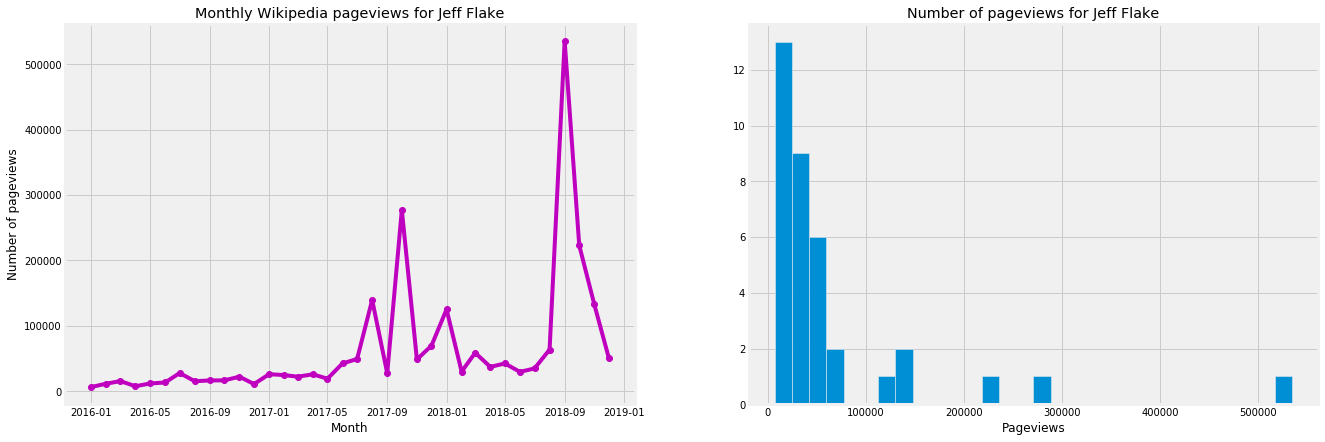

In [180]:
# 1st Legislator: [Jeff Flake]

plt.figure(figsize=[20, 7])

flake = congress.select('Month', 'Jeff_Flake')

plt.subplot(121)
plt.plot(flake['Month'], flake['Jeff_Flake'], 'mo-')
plt.title('Monthly Wikipedia pageviews for Jeff Flake')
plt.xlabel('Month')
plt.ylabel('Number of pageviews');

plt.subplot(122)
plt.hist(flake['Jeff_Flake'], bins=30)
plt.title('Number of pageviews for Jeff Flake')
plt.xlabel('Pageviews');

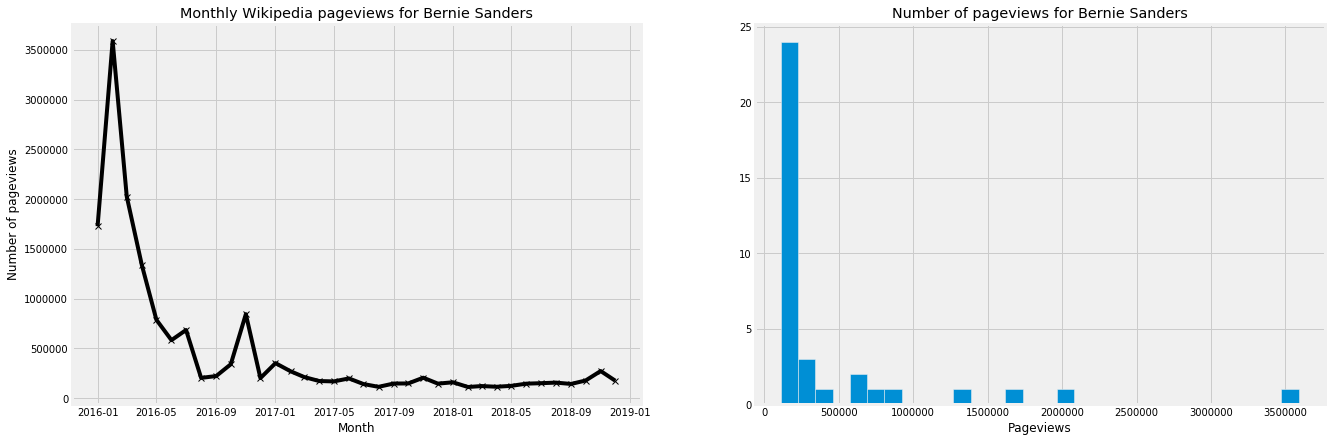

In [200]:
# 2nd Legislator: [Bernie Sanders]

plt.figure(figsize=[20, 7])

sanders = congress.select('Month', 'Bernie_Sanders')

plt.subplot(121)
plt.plot(sanders['Month'], sanders['Bernie_Sanders'], 'kx-')
plt.title('Monthly Wikipedia pageviews for Bernie Sanders')
plt.xlabel('Month')
plt.ylabel('Number of pageviews');

plt.subplot(122)
plt.hist(sanders['Bernie_Sanders'], bins=30)
plt.title('Number of pageviews for Bernie Sanders')
plt.xlabel('Pageviews');

Data visualization is a powerful tool in many apsects of data science, from data exploration to finished analyses. Mastering `pyplot`, which underlies all plotting libraries in Python, is an important step to being able to make powerful, informative visulatizations. The next step in the process is to start learning about another library, like `seaborn` or `altair`, which make plotting more intuitive and responsive. If you're interested in data visualization, you should definitely take Data 100, as a large part of that course focuses on how to make good graphics using Python tools beyond just `matplotlib`.

## Submission
To submit this lab, please download this notebook from DataHub and replace the notebook in your Github repository with this notebook. Commit these changes and push them to Github.